In [73]:
!pip install medmnist giotto-tda scikit-learn matplotlib seaborn gudhi

In [91]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import medmnist
import cv2
import skimage
import shap
import pandas as pd
import xgboost as xgb

import gudhi as gd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split



from gtda.homology import CubicalPersistence
from gtda.diagrams import PersistenceImage
from gtda.diagrams import BettiCurve
from gtda.plotting import plot_diagram
from medmnist import RetinaMNIST

from skimage import feature
import skimage.transform as tf

# Set random seed
#np.random.seed(42)

In [92]:
# Load RetinaMNIST dataset (2D colored retina images)

data = RetinaMNIST(split='train', download=True, size=64)
x_train, y_train = data.imgs, data.labels


# First split only once on full RGB images
X_train, X_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train:", X_train.shape, "Test:", X_test.shape)

# Then extract color channels from the split datasets
X_R_train, X_R_test = X_train[..., 0], X_test[..., 0]
X_G_train, X_G_test = X_train[..., 1], X_test[..., 1]
X_B_train, X_B_test = X_train[..., 2], X_test[..., 2]
X_gray_train, X_gray_test = X_train.mean(axis=-1), X_test.mean(axis=-1)

print("Train Red:", X_R_train.shape, "Test Red:", X_R_test.shape)
print("Train Green:", X_G_train.shape, "Test Green:", X_G_test.shape)
print("Train Blue:", X_B_train.shape, "Test Blue:", X_B_test.shape)
print("Train Gray:", X_gray_train.shape, "Test Gray:", X_gray_test.shape)

Train: (864, 64, 64, 3) Test: (216, 64, 64, 3)
Train Red: (864, 64, 64) Test Red: (216, 64, 64)
Train Green: (864, 64, 64) Test Green: (216, 64, 64)
Train Blue: (864, 64, 64) Test Blue: (216, 64, 64)
Train Gray: (864, 64, 64) Test Gray: (216, 64, 64)


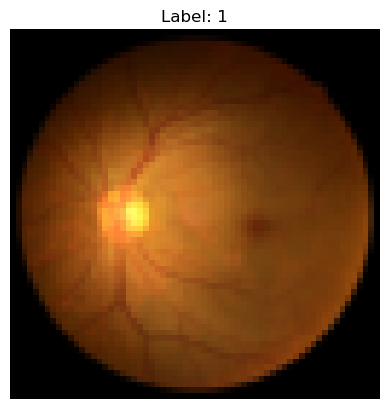

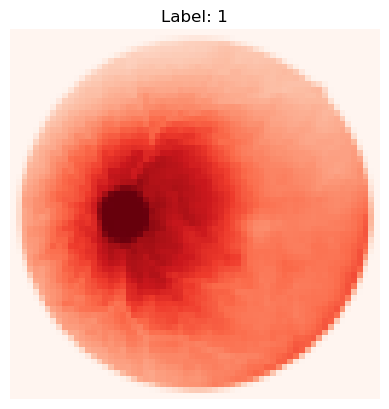

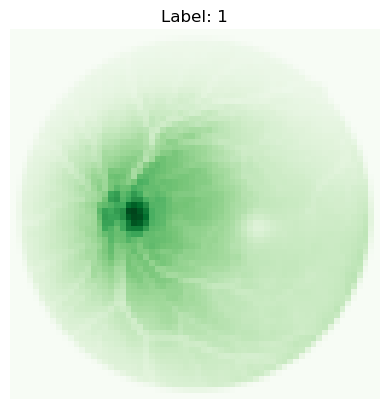

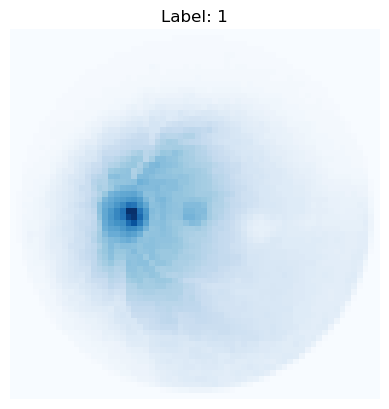

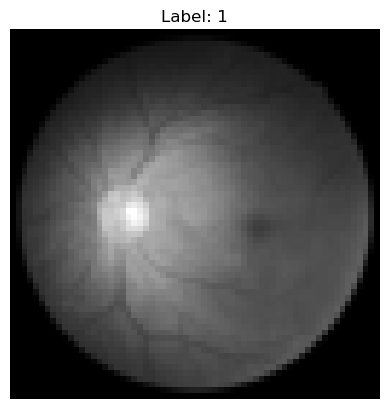

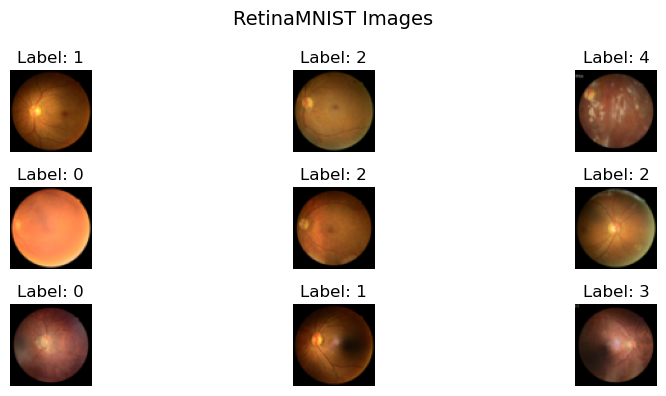

In [93]:
# Choose a single ultrasound image sample from the train set
sample = X_train[0]
sample_R = X_R_train[0]
sample_G = X_G_train[0]
sample_B = X_B_train[0]
sample_gray = X_gray_train[0]

#Plot the sample images

plt.imshow(sample)
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

plt.imshow(sample_R, cmap="Reds")
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

plt.imshow(sample_G, cmap="Greens")
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

plt.imshow(sample_B, cmap="Blues")
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()

plt.imshow(sample_gray, cmap='gray')
plt.title(f"Label: {y_train[0][0]}")
plt.axis('off')
plt.show()
#Plot more samples from the train set

plt.figure(figsize=(10, 4))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i][0]}")
    plt.axis('off')
plt.suptitle("RetinaMNIST Images", fontsize=14)
plt.tight_layout()
plt.show()

In [94]:
# Store Cubical Persistence

cp = CubicalPersistence(homology_dimensions=[0, 1], coeff=3, n_jobs=-1)
cp0 = CubicalPersistence(homology_dimensions=[0], coeff=3, n_jobs=-1)
cp1 = CubicalPersistence(homology_dimensions=[1], coeff=3, n_jobs=-1)

In [95]:
# Persistent Diagrams
diagrams_R = cp.fit_transform(X_R_train)
diagrams_test_R = cp.fit_transform(X_R_test)

diagrams_G = cp.fit_transform(X_G_train)
diagrams_test_G = cp.fit_transform(X_G_test)

diagrams_B = cp.fit_transform(X_B_train)
diagrams_test_B = cp.fit_transform(X_B_test)

diagrams_gray = cp.fit_transform(X_gray_train)
diagrams_test_gray = cp.fit_transform(X_gray_test)

diagrams_RGB = cp.fit_transform(X_train)
diagrams_test_RGB = cp.fit_transform(X_test)

diagram_sample = cp.fit_transform(sample[None, :, :])

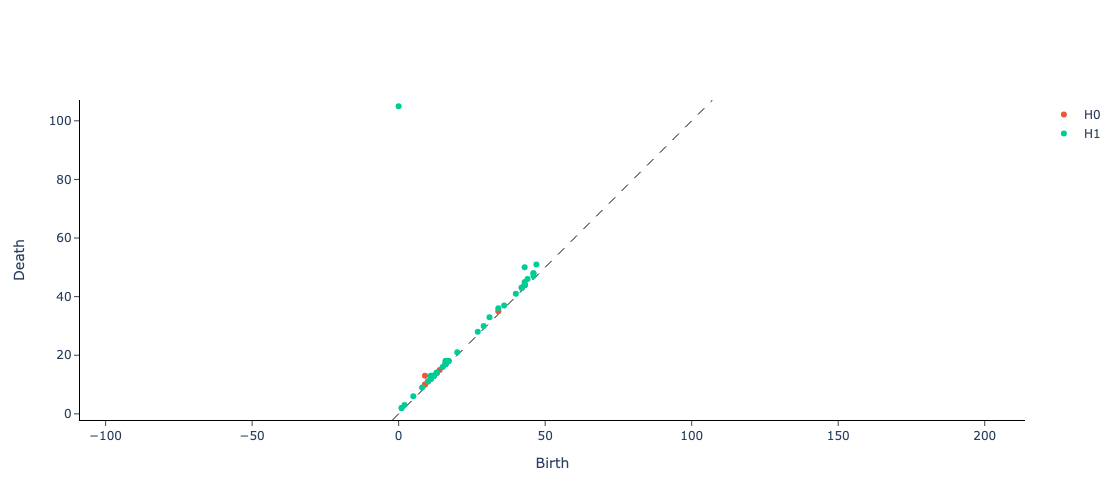

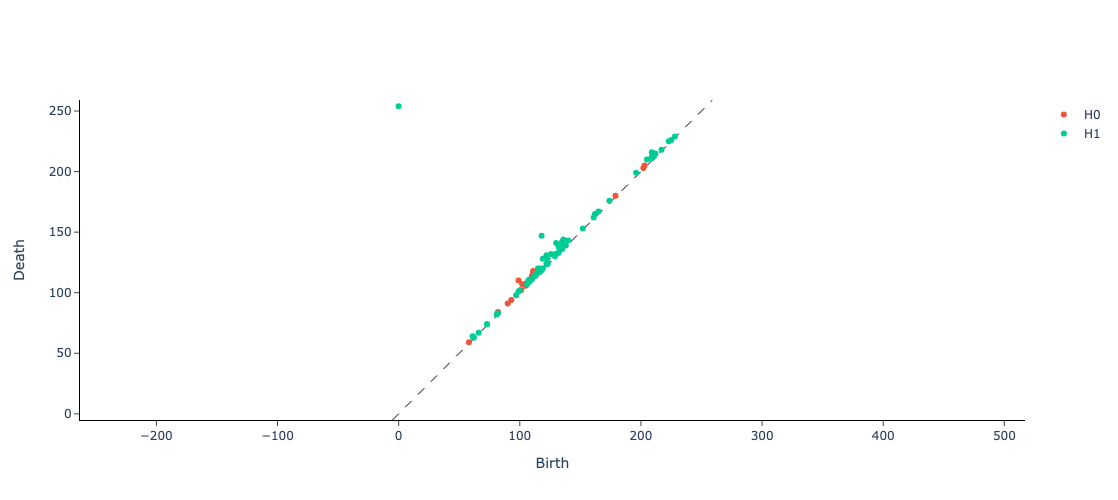

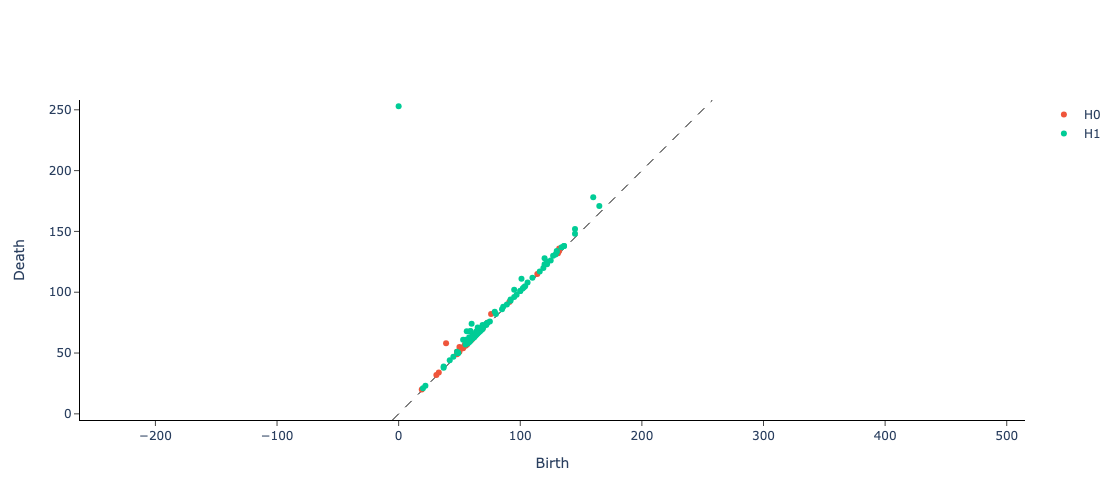

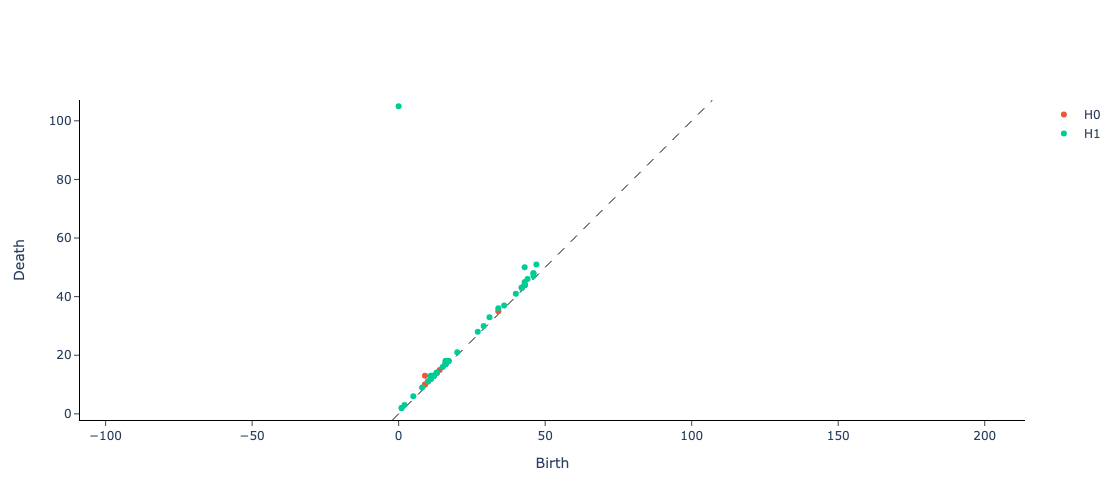

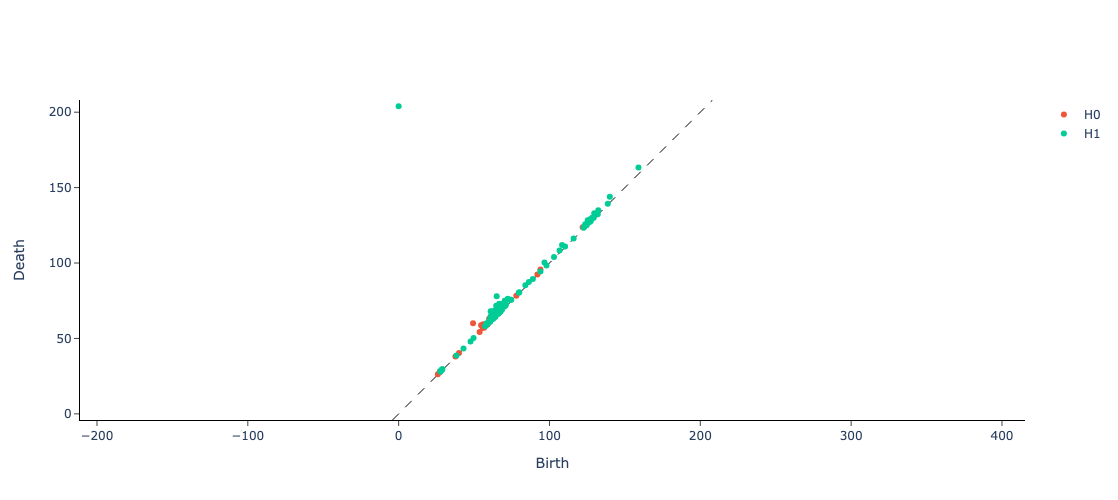

In [96]:
fig1 = plot_diagram(diagrams_RGB[0]) 
fig1.show()

fig2 = plot_diagram(diagrams_R[0])
fig2.show()

fig3 = plot_diagram(diagrams_G[0])
fig3.show()

fig4 = plot_diagram(diagrams_B[0])
fig4.show()

fig5 = plot_diagram(diagrams_gray[0])
fig5.show()

In [97]:
bc = BettiCurve(n_bins = 50)

betti_curves_R = bc.fit_transform(diagrams_R)
betti_curves_R_test = bc.fit_transform(diagrams_test_R)

betti_curves_G = bc.fit_transform(diagrams_G)
betti_curves_G_test = bc.fit_transform(diagrams_test_G)

betti_curves_B = bc.fit_transform(diagrams_B)
betti_curves_B_test = bc.fit_transform(diagrams_test_B)

betti_curves_gray = bc.fit_transform(diagrams_gray)
betti_curves_gray_test = bc.fit_transform(diagrams_test_gray)

betti_curves_RGB = bc.fit_transform(diagrams_RGB)
betti_curves_RGB_test = bc.fit_transform(diagrams_test_RGB)

betti_features = np.hstack([betti_curves_R, betti_curves_G, betti_curves_B, betti_curves_gray])  
betti_features_test = np.hstack([betti_curves_R_test, betti_curves_G_test, betti_curves_B_test, betti_curves_gray_test]) 

print(betti_features.shape)
print(betti_features_test.shape)

(864, 8, 50)
(216, 8, 50)


In [98]:
#### Training Classification Models #####

In [99]:
# Initializers

y_train_m = y_train.ravel() # (n_samples,)
y_test_m = y_test.ravel()


# Vectorization 

X_vec = betti_features.reshape(betti_features.shape[0], -1)
X_test_vec = betti_features_test.reshape(betti_features_test.shape[0], -1)

X_RGB_vec = betti_curves.reshape(betti_curves.shape[0], -1)
X_test_RGB_vec = betti_curve_test.reshape(betti_curve_test.shape[0], -1)


X_R_vec = betti_curves_R.reshape(betti_curves_R.shape[0], -1)
X_R_test_vec = betti_curves_R_test.reshape(betti_curves_R_test.shape[0], -1)

print("Test_R:", X_R_test_vec.shape, y_test_m.shape)
print("Train_R:", X_R_vec.shape, y_train_m.shape)

X_G_vec = betti_curves_G.reshape(betti_curves_G.shape[0], -1)
X_G_test_vec = betti_curves_G_test.reshape(betti_curves_G_test.shape[0], -1)

X_B_vec = betti_curves_B.reshape(betti_curves_B.shape[0], -1)
X_B_test_vec = betti_curves_B_test.reshape(betti_curves_B_test.shape[0], -1)

X_gray_vec = betti_curves_gray.reshape(betti_curves_gray.shape[0], -1)
X_gray_test_vec = betti_curves_gray_test.reshape(betti_curves_gray_test.shape[0], -1)

Test_R: (216, 100) (216,)
Train_R: (864, 100) (864,)


In [105]:
import numpy as np
np.unique(y_train_m)

num_classes = len(np.unique(y_train_m))

[0]	validation_0-mlogloss:1.55472
[10]	validation_0-mlogloss:1.32263
[20]	validation_0-mlogloss:1.25635
[30]	validation_0-mlogloss:1.24447
[40]	validation_0-mlogloss:1.25123
[50]	validation_0-mlogloss:1.25175
[53]	validation_0-mlogloss:1.26251
XGBoost Accuracy: 0.49074074074074076
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        97
           1       0.30      0.12      0.17        26
           2       0.27      0.27      0.27        41
           3       0.36      0.38      0.37        39
           4       0.17      0.08      0.11        13

    accuracy                           0.49       216
   macro avg       0.35      0.33      0.32       216
weighted avg       0.45      0.49      0.46       216

Multiclass ROC AUC: 0.7175734652994133


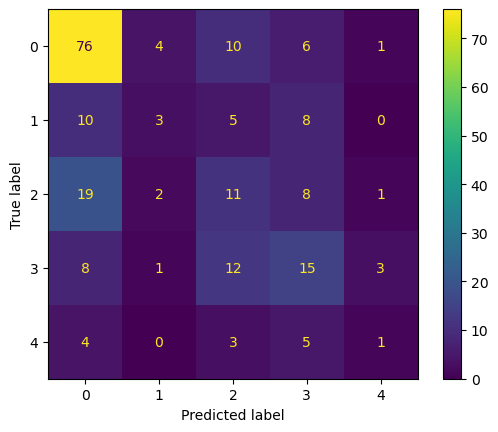

In [106]:
# Train XGBoost model on RetinaMNIST dataset with the original Betti feature vector (100-dim) for each channel

xgb_model = XGBClassifier(
    n_estimators=300,        # number of trees (boosting rounds)
    learning_rate=0.1,       # step size shrinkage
    max_depth=5,             # maximum depth of trees
    subsample=0.8,           # fraction of training samples used per tree
    colsample_bytree=0.8,    # fraction of features used per tree
    random_state=42,
    use_label_encoder=False,
    early_stopping_rounds=20,
    eval_metric="mlogloss",     # <-- multiclass log loss
    objective="multi:softprob", # <-- multiclass classification
    num_class=num_classes  # <-- number of classes in RetinaMNIST
)

# Fit model 
xgb_model.fit(X_vec, y_train_m, eval_set=[(X_test_vec, y_test_m)], verbose=10)

# Predict
y_train_pred = xgb_model.predict(X_vec)
y_train_proba = xgb_model.predict_proba(X_vec)[:, 1] 

y_pred_xgb = xgb_model.predict(X_test_vec)
y_proba_xgb = xgb_model.predict_proba(X_test_vec)

# Multiclass ROC AUC
auc = roc_auc_score(y_test_m, y_proba_xgb, multi_class="ovr", average="macro")


# Evaluate


print("XGBoost Accuracy:", accuracy_score(y_test_m, y_pred_xgb))
print(classification_report(y_test_m, y_pred_xgb))
print("Multiclass ROC AUC:", auc)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_xgb)
plt.show()

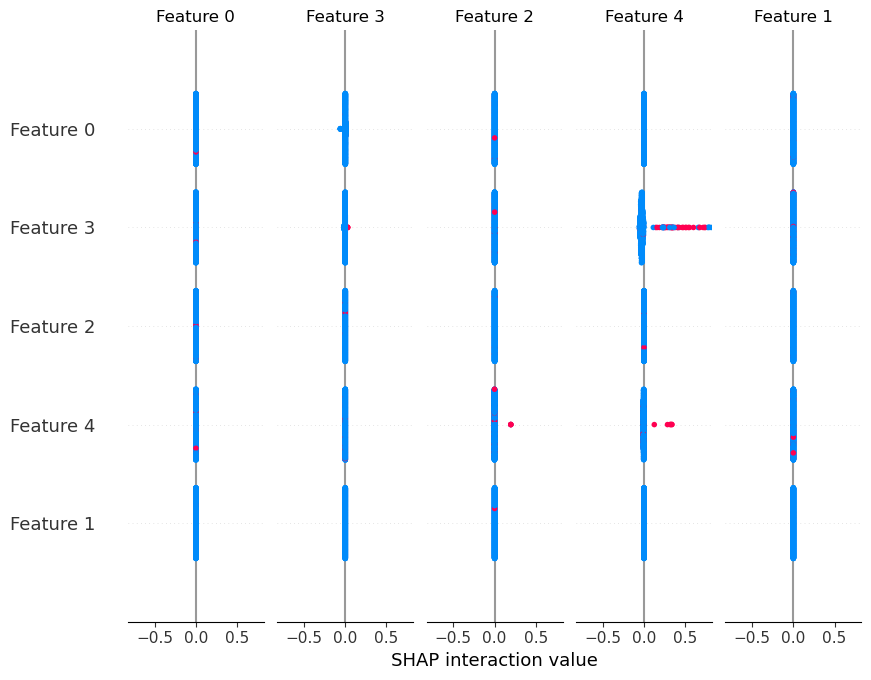

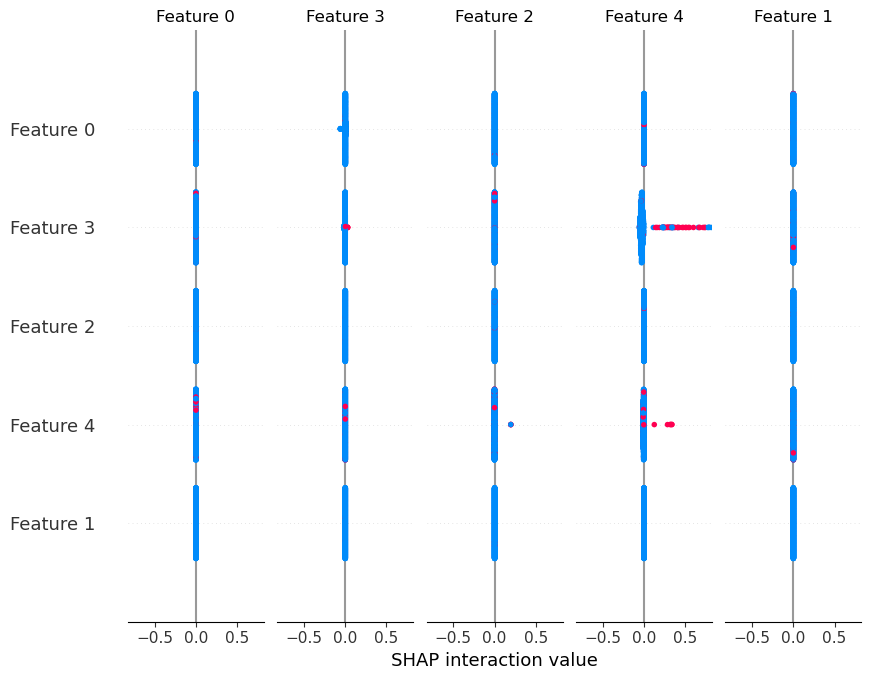

In [107]:
# Get the feature importance scores, shap values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_vec)

shap.summary_plot(shap_values, X_vec, plot_type="bar")
shap.summary_plot(shap_values, X_vec)

[0]	validation_0-mlogloss:1.57928
[10]	validation_0-mlogloss:1.43583
[20]	validation_0-mlogloss:1.39898
[30]	validation_0-mlogloss:1.38901
[40]	validation_0-mlogloss:1.38604
[50]	validation_0-mlogloss:1.38506
[60]	validation_0-mlogloss:1.38429
[70]	validation_0-mlogloss:1.38403
[80]	validation_0-mlogloss:1.38388
[90]	validation_0-mlogloss:1.38369
[100]	validation_0-mlogloss:1.38330
[110]	validation_0-mlogloss:1.38302
[120]	validation_0-mlogloss:1.38291
[130]	validation_0-mlogloss:1.38286
[140]	validation_0-mlogloss:1.38289
[150]	validation_0-mlogloss:1.38287
Reduced XGBoost Model Accuracy: 0.4675925925925926
              precision    recall  f1-score   support

           0       0.47      0.98      0.63        97
           1       0.00      0.00      0.00        26
           2       0.00      0.00      0.00        41
           3       0.50      0.15      0.24        39
           4       0.00      0.00      0.00        13

    accuracy                           0.47       216
   m

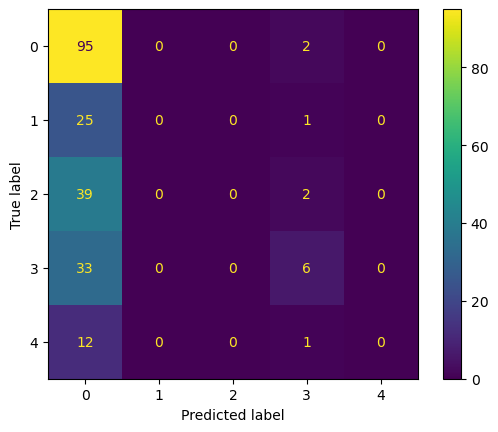

In [109]:
feature_importances = np.mean([np.abs(sv) for sv in shap_values], axis=0)  # shape: (n_features,)
top_features_idx = np.argsort(feature_importances)[-100:]
# Flatten 3D data (samples, 50, 5) → (samples, 250)
X_vec_reduced_flat = X_vec_reduced.reshape(X_vec_reduced.shape[0], -1)
X_test_vec_reduced_flat = X_test_vec_reduced.reshape(X_test_vec_reduced.shape[0], -1)

# Fit XGBoost
xgb_model_reduced = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    objective="multi:softprob",
    num_class=num_classes,  # total number of classes
    early_stopping_rounds=20
)

xgb_model_reduced.fit(
    X_vec_reduced_flat,
    y_train_m,
    eval_set=[(X_test_vec_reduced_flat, y_test_m)],
    verbose=10
)

# Predictions
y_pred_xgb = xgb_model_reduced.predict(X_test_vec_reduced_flat)
y_proba_xgb = xgb_model_reduced.predict_proba(X_test_vec_reduced_flat)

# Accuracy
acc = accuracy_score(y_test_m, y_pred_xgb)
print("Reduced XGBoost Model Accuracy:", acc)

# Classification report with macro F1
print(classification_report(y_test_m, y_pred_xgb, zero_division=0))
macro_f1 = f1_score(y_test_m, y_pred_xgb, average="macro")
print("Macro F1-score:", macro_f1)

# Multiclass ROC-AUC
roc_auc = roc_auc_score(y_test_m, y_proba_xgb, multi_class="ovr", average="macro")
print("Multiclass ROC-AUC:", roc_auc)

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_m, y_pred_xgb)
plt.show()